In [1]:
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
import sys
import cv2
import numpy as np
import pytesseract
from datetime import datetime
import keras_ocr

# Set the Tesseract executable path
pytesseract.pytesseract.tesseract_cmd = '/usr/local/bin/tesseract'  # Adjust the path if needed

2023-09-30 20:03:32.998347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [56]:
def extract_text_pytesseract(image_path):

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    invGamma = 1.0 / 0.3
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype(
        "uint8"
    )

    # apply gamma correction using the lookup table
    gray = cv2.LUT(gray, table)

    ret, thresh1 = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[
        -2:
    ]


    def biggestRectangle(contours):
        biggest = None
        max_area = 0
        indexReturn = -1
        for index in range(len(contours)):
            i = contours[index]
            area = cv2.contourArea(i)
            if area > 100:
                peri = cv2.arcLength(i, True)
                approx = cv2.approxPolyDP(i, 0.1 * peri, True)
                if area > max_area:  # and len(approx)==4:
                    biggest = approx
                    max_area = area
                    indexReturn = index
        return indexReturn


    indexReturn = biggestRectangle(contours)
    hull = cv2.convexHull(contours[indexReturn])

    # create a crop mask
    mask = np.zeros_like(img)  # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, contours, indexReturn, 255, -1)  # Draw filled contour in mask
    out = np.zeros_like(img)  # Extract out the object and place into output image
    out[mask == 255] = img[mask == 255]

    # crop the image
    (y, x, _) = np.where(mask == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = img[topy : bottomy + 1, topx : bottomx + 1, :]


    # predict tesseract
    lang = "eng+nld"
    config = "--psm 11 --oem 3"
    out_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)



    img_data = pytesseract.image_to_data(
        out_rgb,
        lang=lang,
        config=config,
        output_type=pytesseract.Output.DATAFRAME,
    )
    img_conf_text = img_data[["conf", "text"]]
    img_valid = img_conf_text[img_conf_text["text"].notnull()]
    img_words = img_valid[img_valid["text"].str.len() > 1]

    text = img_words["text"].to_list()
    
    return text


def extract_text_keras_ocr(image_path):

    # Preprocess the image (convert to RGB and resize to a specific height)
    image = cv2.imread(image_path)

    # Create an instance of the Keras OCR pipeline
    pipeline = keras_ocr.pipeline.Pipeline()

    # Perform text recognition
    predictions = pipeline.recognize([image])

    # Extract the recognized text
    pred = predictions[0]
    
    # Plot the image with bounding boxes
    image = cv2.imread(image_path)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    keras_ocr.tools.drawAnnotations(image, pred, ax)
    
    # Final text
    text = [entry[0] for entry in pred]
    
    return text


def compute_jaccard_score(text1, text2):

    # Convert the lists to sets
    set1 = set(text1)
    set2 = set(text2)

    # Calculate the intersection and union of the sets
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    # Calculate the Jaccard similarity score
    jaccard_score = intersection / union
    
    return jaccard_score

Looking for /Users/tanvirislam/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/tanvirislam/.keras-ocr/crnn_kurapan.h5
2/2 [==============================] - 4s 697ms/step


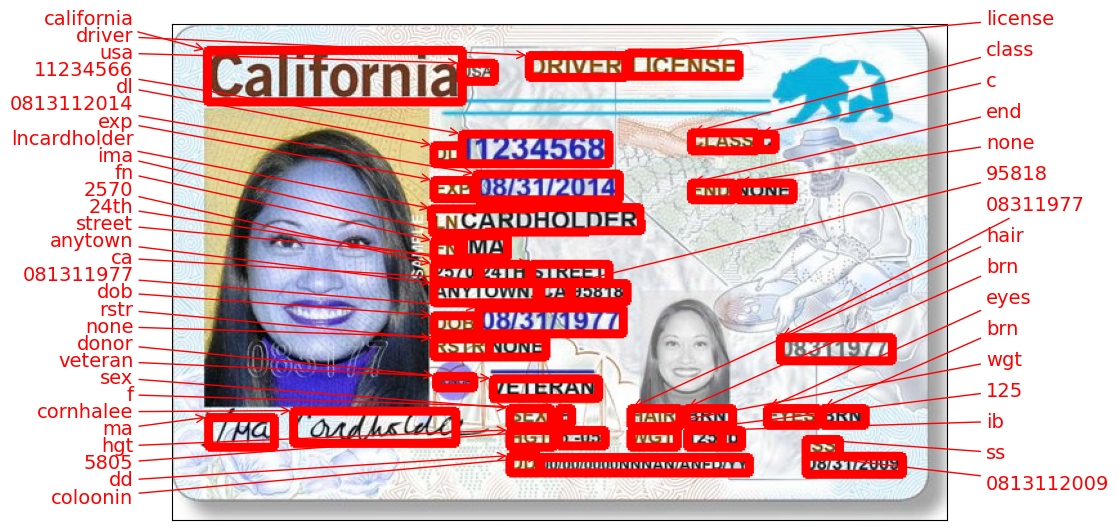

In [25]:
image_path = 'dl_sample1.jpg'
text1 = extract_text_keras_ocr(image_path)

Looking for /Users/tanvirislam/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/tanvirislam/.keras-ocr/crnn_kurapan.h5
2/2 [==============================] - 3s 475ms/step


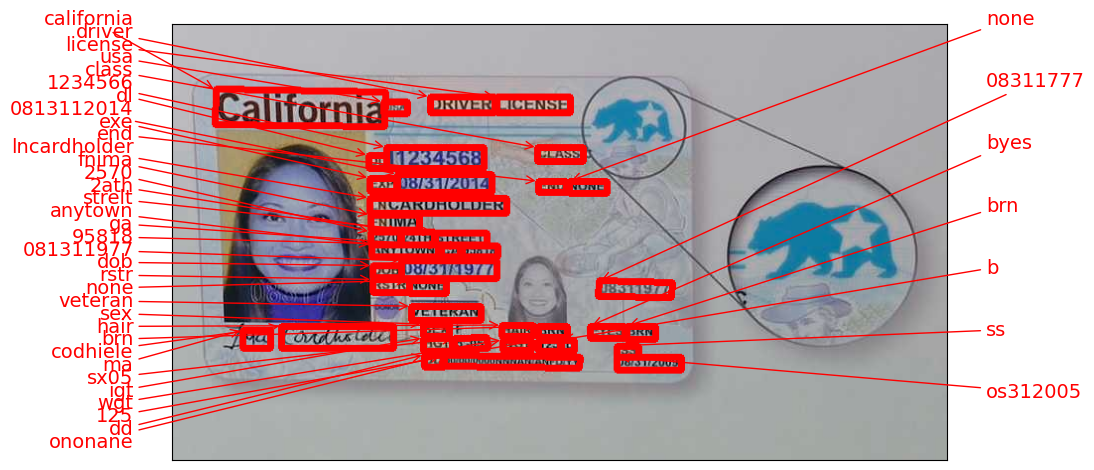

In [52]:
image_path = 'dl_sample5.jpg'
text2 = extract_text_keras_ocr(image_path)

In [53]:
# Jaccard score
jaccard_score = compute_jaccard_score(text1, text2)
jaccard_score

0.43859649122807015

In [66]:
image_path = 'dl_sample1.jpg'
text1 = extract_text_pytesseract(image_path )

image_path = 'dl_sample4.jpg'
text2 = extract_text_pytesseract(image_path)
jaccard_score = compute_jaccard_score(text1, text2)
jaccard_score

0.08108108108108109